In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from lenet.nn.conv import LeNet
from imutils import paths
import imutils
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

Using TensorFlow backend.
C:\Users\Yahia.Kala\Anaconda3\envs\stream1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Yahia.Kala\Anaconda3\envs\stream1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Yahia.Kala\Anaconda3\envs\stream1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Yahia.Kala\Anacon

In [4]:
args = {}
args['dataset'] = './SMILEs'
args['model'] = './model2.h5'

In [5]:
# initialize the list of data and labels
data = []
labels = []

# loop over the input images
for imagePath in sorted(list(paths.list_images(args['dataset']))):
    # load the image, pre-process it, and store in the data list
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = imutils.resize(image, width=28) # 28 x 28 x 1
    image = img_to_array(image)
    data.append(image)

    # extravt the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-3] # C:\Users\Balaji\Documents\Smile-Detector\SMILEs\positives\positives7\3.jpg
    label = 'smiling' if label == 'positives' else 'not_smiling'
    labels.append(label)

In [6]:
len(data), len(labels)

(13165, 13165)

In [18]:
np.shape(data[0])

(28, 28, 1)

In [14]:
labels[0:3]

['not_smiling', 'not_smiling', 'not_smiling']

In [19]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype='float') / 255.0 # 0 to 255
labels = np.array(labels)

In [20]:
# convert the labels from integers to vectors
le = LabelEncoder().fit(labels)
labels = np_utils.to_categorical(le.transform(labels), 2)

In [21]:
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = dict()


for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]

In [22]:
# partition the data into training and testing sploits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels,
                                                  test_size=0.20,
                                                  stratify=labels,
                                                  random_state=42)


In [23]:

# initialize the model
print('[INFO] compiling model...')
model = LeNet.build(width=28, height=28, depth=1, classes=2)
model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['accuracy'])


[INFO] compiling model...



In [24]:
# train the network
print('[INFO] training network...')
H = model.fit(trainX, trainY, validation_data=(testX, testY),
              class_weight=classWeight, batch_size=64, epochs=15, verbose=1)


[INFO] training network...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 10532 samples, validate on 2633 samples
Epoch 1/15
10532/10532 [==============================] - 11s 1ms/step - loss: 0.6114 - accuracy: 0.7964 - val_loss: 0.3355 - val_accuracy: 0.8621
Epoch 2/15
10532/10532 [==============================] - 10s 971us/step - loss: 0.4347 - accuracy: 0.8739 - val_loss: 0.3641 - val_accuracy: 0.8382
Epoch 3/15
10532/10532 [==============================] - 10s 980us/step - loss: 0.4016 - accuracy: 0.8883 - val_loss: 0.2725 - val_accuracy: 0.8883
Epoch 4/15
10532/10532 [==============================] - 11s 1ms/step - loss: 0.3671 - accuracy: 0.8987 - val_loss: 0.2419 - val_accuracy: 0.9028
Epoch 5/15
10532/10532 [==============================] - 10s 994us/step - loss: 0.3438 - accuracy: 0.9056 - val_loss: 0.2529 - val_accuracy: 0.8963
Epoch 6/15
10532/10532 [==============================] - 10s 985us/step - loss: 0.3264 

In [25]:
# evaluate the network
print('[INFO] evaluating network...')
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=le.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

 not_smiling       0.94      0.94      0.94      1895
     smiling       0.84      0.84      0.84       738

    accuracy                           0.91      2633
   macro avg       0.89      0.89      0.89      2633
weighted avg       0.91      0.91      0.91      2633



In [26]:
# save the model to disk
print('[INFO] serializing network')
model.save(args['model'])

[INFO] serializing network


In [28]:
model.save('./model4')

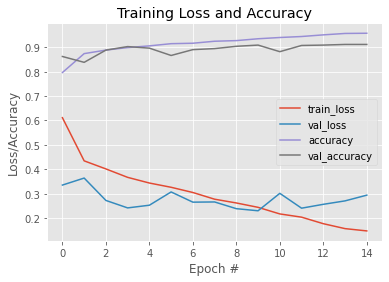

In [27]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, 15), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 15), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, 15), H.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, 15), H.history['val_accuracy'], label='val_accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()